# ECON 470 Homework 3
### Ellen Wu

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from causalinference import CausalModel
from IPython.display import Markdown, display
from linearmodels.iv import IV2SLS
import warnings
warnings.simplefilter('ignore')

In [36]:
# Load data
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")
df['tax_change'] = df.groupby('state')['tax_state'].diff().notna()

1. Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.

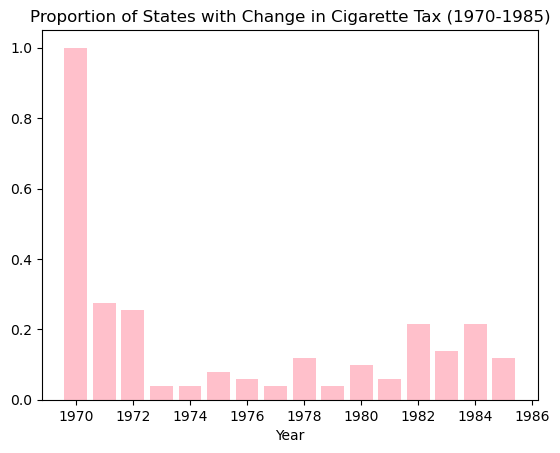

In [37]:
#finding prop of states that had change in tax from 1970-1986
df = df.sort_values(by=['state', 'Year'])
df = df[(df['Year']>=1970) & (df['Year']<=1985)]
df['tax_change'] = df.groupby('state')['tax_state'].diff().ne(0).astype(int)
tax_change = df.groupby('Year')['tax_change'].mean()


plt.bar(tax_change.index, tax_change.values, color='pink')
plt.title('Proportion of States with Change in Cigarette Tax (1970-1985)')
plt.xlabel('Year')
plt.show()

2. Plot on a single graph the average tax (in 2012 dollars) on cigarettes and the average price of a pack of cigarettes from 1970 to 2018.

In [46]:
df = pd.read_csv("/Users/ellenwu/homework3/data/output/Taxburden_data.csv")
 
# Filter for years 1970 to 2018
df = df[(df['Year'] >= 1970) & (df['Year'] <= 2018)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

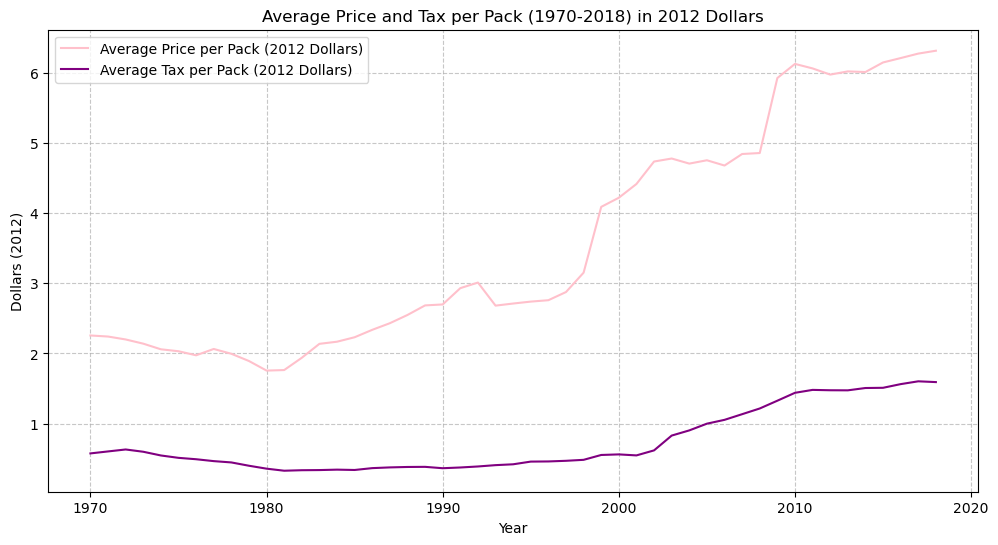

In [47]:
# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='pink')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='purple')

plt.title('Average Price and Tax per Pack (1970-2018) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

3. Identify the 5 states with the highest increases in cigarette prices (in dollars) over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [48]:
# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

print("Top 5 states with highest cigarette price increases:")
print(top5_states)

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

Top 5 states with highest cigarette price increases:
32                New York
8     District of Columbia
6              Connecticut
39            Rhode Island
21           Massachusetts
Name: state, dtype: object


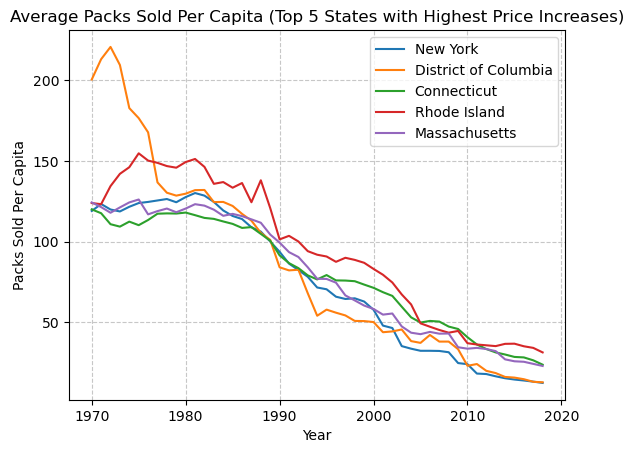

In [49]:
for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

4. Identify the 5 states with the lowest increases in cigarette prices over the time period. Plot the average number of packs sold per capita for those states from 1970 to 2018.

In [50]:
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()

# Calculate the total increase in price
price_change['price_increase'] = price_change['last'] - price_change['first']

bottom5_states = price_change.sort_values('price_increase', ascending=True).head(5)['state']

print("5 states with the lowest cigarette price increases:")
print(bottom5_states.tolist())

bottom5_df = df[df['state'].isin(bottom5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = bottom5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

5 states with the lowest cigarette price increases:
['Missouri', 'North Dakota', 'Tennessee', 'Georgia', 'North Carolina']


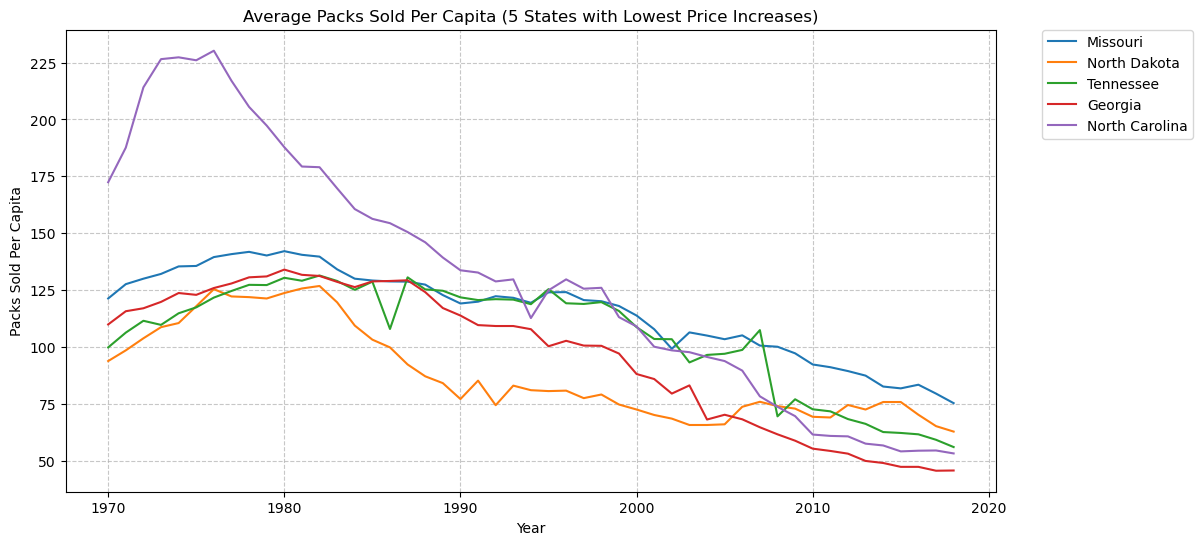

In [51]:
plt.figure(figsize=(12, 6))

for state in bottom5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (5 States with Lowest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

5. Compare the trends in sales from the 5 states with the highest price increases to those with the lowest price increases.

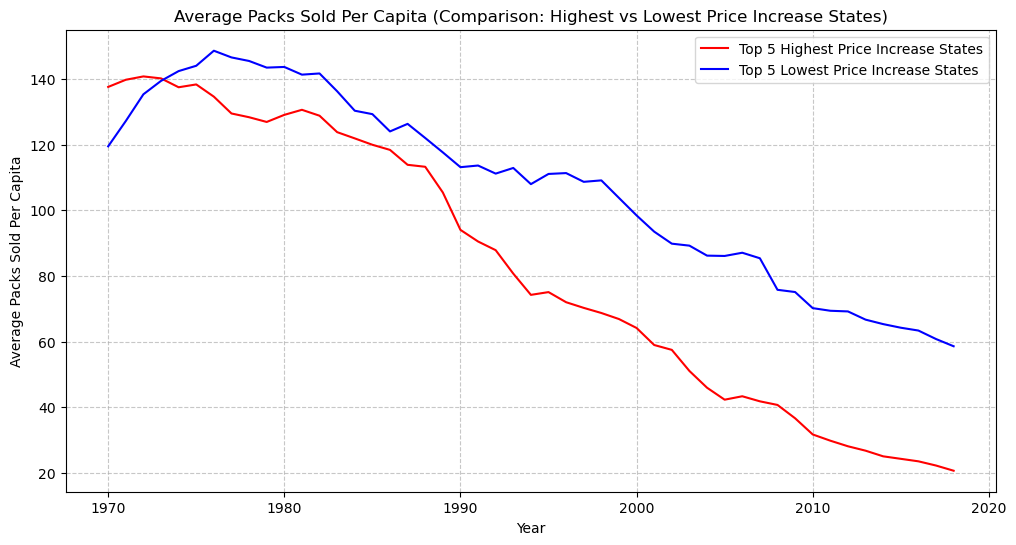

In [52]:
# Group by year and calculate mean sales_per_capita for each group (top 5 and bottom 5)

top5_avg = top5_df.groupby('Year')['sales_per_capita'].mean().reset_index()
bottom5_avg = bottom5_df.groupby('Year')['sales_per_capita'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(top5_avg['Year'], top5_avg['sales_per_capita'], label='Top 5 Highest Price Increase States', color='red')
plt.plot(bottom5_avg['Year'], bottom5_avg['sales_per_capita'], label='Top 5 Lowest Price Increase States', color='blue')

plt.title('Average Packs Sold Per Capita (Comparison: Highest vs Lowest Price Increase States)')
plt.xlabel('Year')
plt.ylabel('Average Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The five states with the highest increases in cigarette prices experienced a sharp decline in packs sold per capita from 1970 to 2018, reflecting the impact of higher prices and likely stronger tobacco control policies. In contrast, the five states with the lowest price increases saw higher and more stable cigarette consumption over time, with only a gradual decline. This suggests that states with smaller price hikes, many of which are historically tied to tobacco production, were less aggressive in discouraging smoking through price-based policies.

6. Focusing only on the time period from 1970 to 1990, regress log sales on log prices to estimate the price elasticity of demand over that period. Interpret your results.

In [54]:
# Filter for 1970-1990
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1990)]

# Drop rows with missing values in price or sales
df = df.dropna(subset=['cost_per_pack', 'sales_per_capita'])

# Take logs
df['log_sales_per_capita'] = np.log(df['sales_per_capita'])
df['log_price_per_pack'] = np.log(df['cost_per_pack'])

# Regression: log(sales_per_capita) ~ log(cost_per_pack)
X = sm.add_constant(df['log_price_per_pack'])  # Add intercept
y = df['log_sales_per_capita']

model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

# Get elasticity (the slope coefficient)
elasticity = model.params['log_price_per_pack']
print(f"Estimated Price Elasticity of Demand: {elasticity:.2f}")

                             OLS Regression Results                             
Dep. Variable:     log_sales_per_capita   R-squared:                       0.126
Model:                              OLS   Adj. R-squared:                  0.125
Method:                   Least Squares   F-statistic:                     153.9
Date:                  Tue, 18 Mar 2025   Prob (F-statistic):           4.18e-33
Time:                          21:44:43   Log-Likelihood:                 148.99
No. Observations:                  1071   AIC:                            -294.0
Df Residuals:                      1069   BIC:                            -284.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

The estimated price elasticity of demand for cigarettes between 1970 and 1990 is approximately -0.093. This indicates that a 10% increase in cigarette prices is associated with a 0.93% decrease in cigarette sales per capita, suggesting that demand for cigarettes was relatively inelastic during this period — meaning consumers were not very responsive to price changes.

7. Again limiting to 1970 to 1990, regress log sales on log prices using the total (federal and state) cigarette tax (in dollars) as an instrument for log prices. Interpret your results and compare your estimates to those without an instrument. Are they different? If so, why?

In [55]:
# Drop rows with missing data in price, sales, or tax
df = df.dropna(subset=['cost_per_pack', 'sales_per_capita', 'tax_dollar'])

# Create log variables
df['log_sales_per_capita'] = np.log(df['sales_per_capita'])
df['log_price_per_pack'] = np.log(df['cost_per_pack'])

# Step 1: Define variables for 2SLS
y = df['log_sales_per_capita']   # Dependent variable
X = df[['log_price_per_pack']]   # Endogenous regressor (price)
Z = df[['tax_dollar']]           # Instrument (tax in dollars)

# Add constant to X (explanatory variables) for the regression
X = sm.add_constant(X)

In [56]:
# Run 2SLS regression
model_iv = IV2SLS(dependent=y, exog=X[['const']], endog=X['log_price_per_pack'], instruments=Z).fit()

# Show results
print(model_iv.summary)

# Get IV estimate of elasticity
elasticity_iv = model_iv.params['log_price_per_pack']
print(f"\nInstrumented Price Elasticity of Demand: {elasticity_iv:.2f}")

                           IV-2SLS Estimation Summary                           
Dep. Variable:     log_sales_per_capita   R-squared:                      0.0841
Estimator:                      IV-2SLS   Adj. R-squared:                 0.0833
No. Observations:                  1071   F-statistic:                    220.14
Date:                  Tue, Mar 18 2025   P-value (F-stat)                0.0000
Time:                          21:44:46   Distribution:                  chi2(1)
Cov. Estimator:                  robust                                         
                                                                                
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  4.7151     0.0081     583.37     0.0000      4.6993      4.7310
log_

Using cigarette taxes as an instrument for prices, the estimated price elasticity of demand for cigarettes between 1970 and 1990 is approximately -0.27. This suggests that a 10% increase in cigarette prices is associated with a 2.6% decrease in cigarette sales per capita, indicating that demand for cigarettes is relatively inelastic. This IV estimate of -0.26 is more elastic than the OLS estimate of -0.093. This suggests that the OLS regression likely underestimated the true price elasticity, possibly due to endogeneity bias — factors like state-level health campaigns or smoking culture may simultaneously influence both cigarette prices and consumption. By using taxes as an instrument, the IV estimate isolates the effect of exogenous price changes caused by policy, giving a clearer picture of how consumers respond to price changes.

8. Show the first stage and reduced-form results from the instrument.

In [57]:
# Filter data for 1970 to 1990
df = df[(df['Year'] >= 1970) & (df['Year'] <= 1990)]

df = df.dropna(subset=['cost_per_pack', 'sales_per_capita', 'tax_dollar'])

# Take logs
df['log_sales_per_capita'] = np.log(df['sales_per_capita'])
df['log_price_per_pack'] = np.log(df['cost_per_pack'])

X_first_stage = sm.add_constant(df['tax_dollar'])
y_first_stage = df['log_price_per_pack']

first_stage_model = sm.OLS(y_first_stage, X_first_stage).fit()
print("First Stage Regression Results:")
print(first_stage_model.summary())

X_reduced_form = sm.add_constant(df['tax_dollar'])
y_reduced_form = df['log_sales_per_capita']

reduced_form_model = sm.OLS(y_reduced_form, X_reduced_form).fit()
print("\nReduced Form Regression Results:")
print(reduced_form_model.summary())

First Stage Regression Results:
                            OLS Regression Results                            
Dep. Variable:     log_price_per_pack   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     2431.
Date:                Tue, 18 Mar 2025   Prob (F-statistic):          1.52e-277
Time:                        21:44:57   Log-Likelihood:                -66.026
No. Observations:                1071   AIC:                             136.1
Df Residuals:                    1069   BIC:                             146.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.428

The first stage regression shows that cigarette taxes are strongly positively associated with cigarette prices, with a statistically significant coefficient, confirming that taxes are a strong and relevant instrument for price.

9. Repeat questions 1-3 focusing on the period from 1991 to 2015.

In [58]:
df = pd.read_csv("/Users/ellenwu/homework3_attempt1-/data/output/TaxBurden_Data.csv")
df['tax_change'] = df.groupby('state')['tax_state'].diff().notna()
prop_change = df.groupby('Year')['tax_change'].mean()

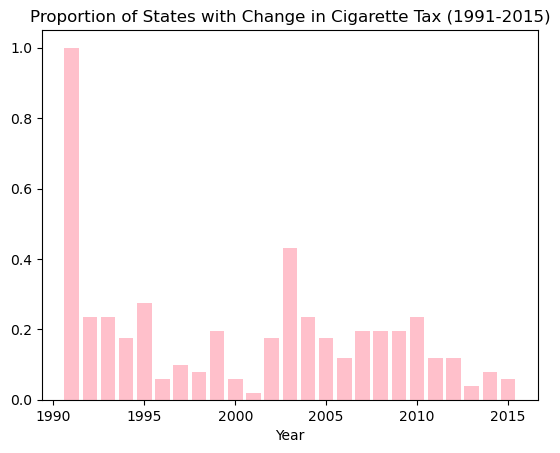

In [60]:
#finding prop of states that had change in tax from 1991-2015
df = df.sort_values(by=['state', 'Year'])
df = df[(df['Year']>=1991) & (df['Year']<=2015)]
df['tax_change'] = df.groupby('state')['tax_state'].diff().ne(0).astype(int)
tax_change = df.groupby('Year')['tax_change'].mean()


plt.bar(tax_change.index, tax_change.values, color='pink')
plt.title('Proportion of States with Change in Cigarette Tax (1991-2015)')
plt.xlabel('Year')
plt.show()

plt.show()

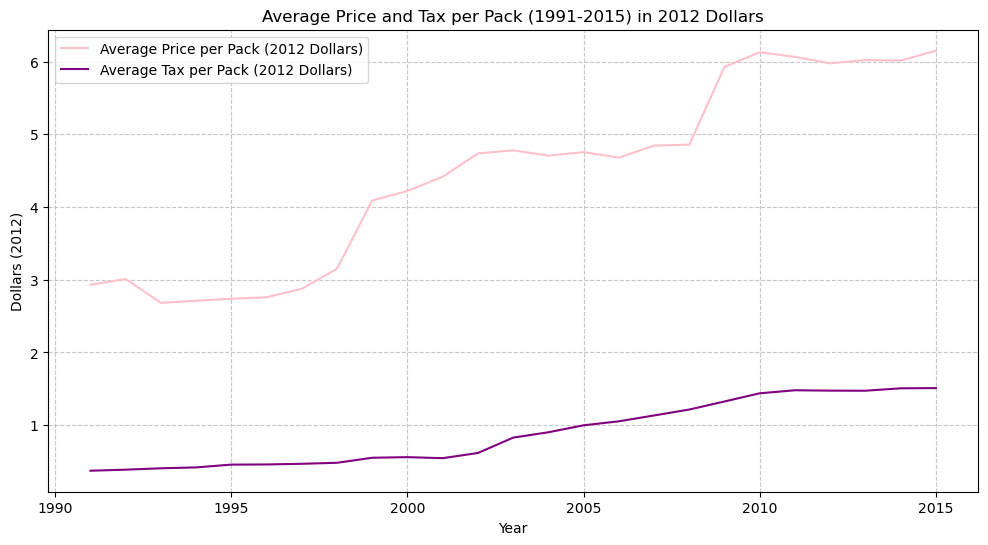

In [61]:
df = df[(df['Year'] >= 1991) & (df['Year'] <= 2015)]

# Use CPI to adjust to 2012 dollars
# Assuming 2012 CPI = 230 (You should check the exact CPI value for 2012 from your dataset if available)
df['cost_per_pack_2012'] = df['cost_per_pack'] * (230 / df['index'])
df['tax_state_2012'] = df['tax_state'] * (230 / df['index'])

# Group by year and compute average across all states
annual_avg = df.groupby('Year').agg({
    'cost_per_pack_2012': 'mean',
    'tax_state_2012': 'mean'
}).reset_index()

# Plot
plt.figure(figsize=(12, 6))

plt.plot(annual_avg['Year'], annual_avg['cost_per_pack_2012'], label='Average Price per Pack (2012 Dollars)', color='pink')
plt.plot(annual_avg['Year'], annual_avg['tax_state_2012'], label='Average Tax per Pack (2012 Dollars)', color='purple')

plt.title('Average Price and Tax per Pack (1991-2015) in 2012 Dollars')
plt.xlabel('Year')
plt.ylabel('Dollars (2012)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

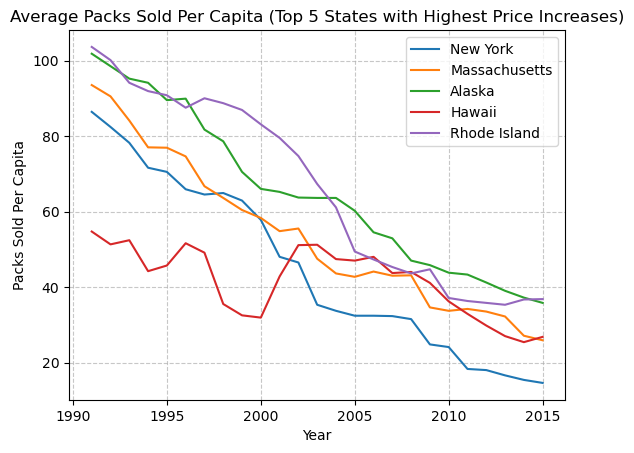

In [62]:
df = df[(df['Year'] >= 1991) & (df['Year'] <= 2015)]

# Identify price change over time per state
price_change = df.groupby('state')['cost_per_pack'].agg(['first', 'last']).reset_index()
price_change['price_increase'] = price_change['last'] - price_change['first']

# Get top 5 states with highest price increases
top5_states = price_change.sort_values('price_increase', ascending=False).head(5)['state']

# Filter dataset to only those states
top5_df = df[df['state'].isin(top5_states)]

# Group by year and state to calculate average packs sold per capita
packs_per_capita = top5_df.groupby(['Year', 'state'])['sales_per_capita'].mean().reset_index()

for state in top5_states:
    state_data = packs_per_capita[packs_per_capita['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'], label=state)

plt.title('Average Packs Sold Per Capita (Top 5 States with Highest Price Increases)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

10. Compare your elasticity estimates from 1970-1990 versus those from 1991-2015. Are they different? If so, why?

In [63]:
df = df[(df['Year'] >= 1991) & (df['Year'] <= 2015)]

# Drop rows with missing values in price or sales
df = df.dropna(subset=['cost_per_pack', 'sales_per_capita'])

# Take logs
df['log_sales_per_capita'] = np.log(df['sales_per_capita'])
df['log_price_per_pack'] = np.log(df['cost_per_pack'])

# Regression: log(sales_per_capita) ~ log(cost_per_pack)
X = sm.add_constant(df['log_price_per_pack'])  # Add intercept
y = df['log_sales_per_capita']

model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

# Get elasticity (the slope coefficient)
elasticity = model.params['log_price_per_pack']
print(f"Estimated Price Elasticity of Demand: {elasticity:.2f}")

                             OLS Regression Results                             
Dep. Variable:     log_sales_per_capita   R-squared:                       0.533
Model:                              OLS   Adj. R-squared:                  0.532
Method:                   Least Squares   F-statistic:                     1451.
Date:                  Tue, 18 Mar 2025   Prob (F-statistic):          1.52e-212
Time:                          21:46:40   Log-Likelihood:                -296.47
No. Observations:                  1275   AIC:                             596.9
Df Residuals:                      1273   BIC:                             607.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           